In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd

# Simulation

In [2]:
N_sim = int(1e5)
dt = 1e-4
dB = np.sqrt(dt)

V_A_old = 0.4
V_A_new = 0.9
a = 2
t_LED = 1

RT_all_sim = np.zeros((N_sim))


In [3]:
def simulate_single_bound_V_A_change(V_A_old, V_A_new, a, t_LED, dt):
    t = 0
    DV = 0

    while True:
        if t >= t_LED:
            v = V_A_new
        else:
            v = V_A_old
        
        t += dt
        DV += v*dt + np.random.normal(0, dB)
        
        if DV >= a:
            return t
        

sim_results = Parallel(n_jobs=-1)(delayed(simulate_single_bound_V_A_change)\
                                  (V_A_old, V_A_new, a, t_LED, dt) for _ in tqdm(range(N_sim)))

100%|██████████| 100000/100000 [01:03<00:00, 1567.97it/s]


# PDF

In [4]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


def P_t_x(x, t, v, a):
    """
    Prob that DV = x at time t given v, a 
    """
    return (1/np.sqrt(2 * (np.pi) * t)) * \
        ( np.exp(-((x - v*t)**2)/(2*t)) - np.exp( 2*v*a - ((x - 2*a - v*t)**2)/(2*t) ) )


def P_old_at_x_times_P_new_hit(x, t, V_A_old, V_A_new, a, t_LED):
    """
    Prob that DV is at x at t_LED and new V_A hits "a-x" bound at t - t_LED
    """
    return P_t_x(x, t_LED, V_A_old, a) * rho_A_t_fn(t-t_LED, V_A_new, a - x)



def PDF_hit_V_A_change(t, V_A_old, V_A_new, a, t_LED):
    """
    PDF of RT of hitting single bound with V_A change at t_LED
    """
    if t <= t_LED:
        p = rho_A_t_fn(t, V_A_old, a)
    else:
        p = quad(P_old_at_x_times_P_new_hit, -np.inf, a, args=(t, V_A_old, V_A_new, a, t_LED))[0]
    
    return p

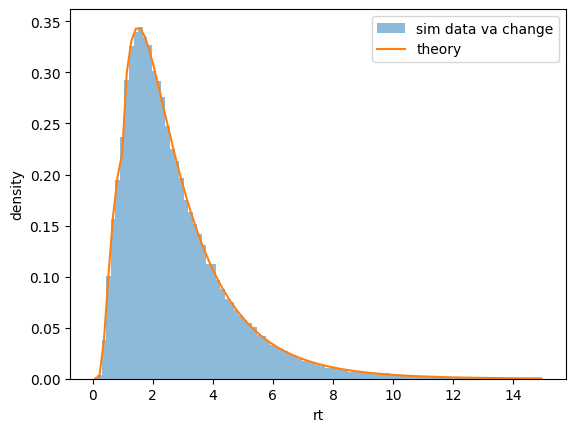

In [5]:
# data
bins = np.linspace(0.001, 15, 100)
plt.hist(sim_results, bins=bins, density=True, alpha=0.5, label='sim data va change');

# theory
t_pts = bins[:-1] + np.diff(bins)/2
theory_pdf = np.array([PDF_hit_V_A_change(t, V_A_old, V_A_new, a, t_LED) for t in t_pts])
plt.plot(t_pts, theory_pdf, label='theory')

plt.xlabel('rt')
plt.ylabel('density')
plt.legend();


# CDF

In [6]:
from scipy.special import erf
def Phi(x):
    """
    Define the normal cumulative distribution function Φ(x) using erf
    """
    return 0.5 * (1 + erf(x / np.sqrt(2)))


def cum_A_t_fn(t, V_A, theta_A):
    """
    For AI, calculate cummulative distrn of a time t given V_A, theta_A
    """
    if t <= 0:
        return 0

    term1 = Phi(V_A * ((t) - (theta_A/V_A)) / np.sqrt(t))
    term2 = np.exp(2 * V_A * theta_A) * Phi(-V_A * ((t) + (theta_A / V_A)) / np.sqrt(t))
    
    return term1 + term2

def P_old_at_x_times_CDF_new_hit(x, t, V_A_old, V_A_new, a, t_LED):
    """
    Prob that DV is at x at t_LED times CDF new V_A hits "a-x" bound at t - t_LED
    A helper func for CDF_hit_V_A_change
    """
    return P_t_x(x, t_LED, V_A_old, a) * cum_A_t_fn(t - t_LED, V_A_new, a - x)

def CDF_hit_V_A_change(t, V_A_old, V_A_new, a, t_LED):
    """
    CDF of hitting bound with V_A change at t_LED
    """
    if t <= t_LED:
        return cum_A_t_fn(t, V_A_old, a)
    else:
        return cum_A_t_fn(t_LED, V_A_old, a) + quad(P_old_at_x_times_CDF_new_hit, -10, a, args=(t, V_A_old, V_A_new, a, t_LED))[0]



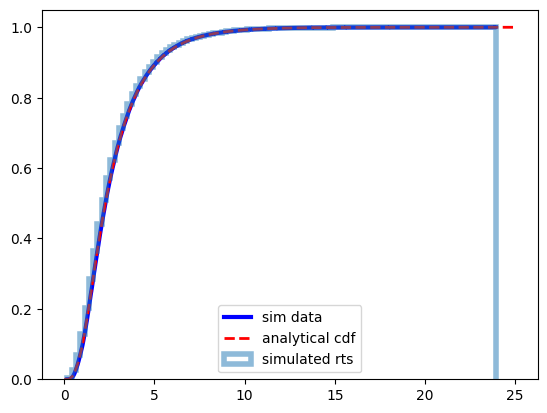

In [22]:
# data - CDF of sim_results
plt.figure()
data_sorted = np.sort(sim_results)
cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
plt.step(data_sorted, cdf, where='post',color='b',lw=3, label='sim data')

t_pts = np.linspace(0.001, 25, 100)
analytical_cdf = np.array([CDF_hit_V_A_change(t, V_A_old, V_A_new, a, t_LED) for t in t_pts])
plt.plot(t_pts, analytical_cdf, label='analytical cdf', color='r',ls='--',lw=2)

plt.hist(sim_results, bins=100, density=True, alpha=0.5, cumulative=True, label='simulated rts', histtype='step', lw=4);

plt.legend();

# ----------------------------------------- Rough work below -------------------------------------------------------------

# const V_A just for debug

In [8]:
# def simulate_single_bound_constant_V_A(v, a, dt):
#     t = 0
#     DV = 0

#     while True:
#         t += 1
#         DV += v*dt + np.random.normal(0, dB)
        
#         if DV >= a:
#             return t*dt
        

# sim_results_const_V_A = Parallel(n_jobs=-1)(delayed(simulate_single_bound_constant_V_A)\
#                                   (V_A_new, a, dt) for _ in tqdm(range(N_sim)))

# theory fit

In [9]:
from scipy.special import erf
def Phi(x):
    """
    Define the normal cumulative distribution function Φ(x) using erf
    """
    return 0.5 * (1 + erf(x / np.sqrt(2)))


# AI
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


def cum_A_t_fn(t, V_A, theta_A):
    """
    For AI, calculate cummulative distrn of a time t given V_A, theta_A
    """
    if t <= 0:
        return 0

    term1 = Phi(V_A * ((t) - (theta_A/V_A)) / np.sqrt(t))
    term2 = np.exp(2 * V_A * theta_A) * Phi(-V_A * ((t) + (theta_A / V_A)) / np.sqrt(t))
    
    return term1 + term2

# Helper funcs

In [10]:
def P_t_x(x, t, v, a):
    return (1/np.sqrt(2 * (np.pi) * t)) * \
        ( np.exp(-((x - v*t)**2)/(2*t)) - np.exp( 2*v*a - ((x - 2*a - v*t)**2)/(2*t) ) )

def P_t(t):
    tau = 0.1; t0 = 0.1
    return np.exp(-(t - t0)/tau)/tau


def P_old_at_x_times_P_new_hit(x, t, V_A_old, V_A_new, a, t_LED):
    return P_t_x(x, t_LED, V_A_old, a) * rho_A_t_fn(t-t_LED, V_A_new, a - x)

def P_old_at_x_times_CDF_new_hit(x, t, V_A_old, V_A_new, a, t_LED):
    return P_t_x(x, t_LED, V_A_old, a) * cum_A_t_fn(t-t_LED, V_A_new, a - x)

# PDF hit with V_A change

In [11]:
def pre_led(t, V_A_old, V_A_new, a, t_LED):
    return rho_A_t_fn(t, V_A_old, a)
def post_led(t, V_A_old, V_A_new, a, t_LED):
    return quad(P_old_at_x_times_P_new_hit, -np.inf, a, args=(t, V_A_old, V_A_new, a, t_LED))[0]
def p_x_t_area(V_A_old, a, t_LED):
    return quad(P_t_x, -np.inf, a, args=(t_LED, V_A_old, a))[0]
def post_led_CDF(t, V_A_old, V_A_new, a, t_LED):
    return quad(P_old_at_x_times_CDF_new_hit, -10, a, args=(t, V_A_old, V_A_new, a, t_LED))[0]

In [12]:
area = p_x_t_area(V_A_old, a, t_LED)
area2 = 1 - cum_A_t_fn(t_LED, V_A_old, a)
print(area, area2, area2/area, np.sqrt(np.pi))

print(post_led_CDF(2, V_A_old, V_A_new, a, t_LED))

0.9045980470657585 0.9045980470657737 1.0000000000000169 1.7724538509055159
0.323044905787913


In [13]:
def PDF_hit_V_A_change(t, V_A_old, V_A_new, a, t_LED, area):

    if t <= t_LED:
        area = 1
        p = pre_led(t, V_A_old, V_A_new, a, t_LED)/area
    else:
        p = post_led(t, V_A_old, V_A_new, a, t_LED)/area
    
    return p

In [14]:
def PDF_hit_V_A_change_NO_AREA(t, V_A_old, V_A_new, a, t_LED):

    if t <= t_LED:
        p = pre_led(t, V_A_old, V_A_new, a, t_LED)
    else:
        p = post_led(t, V_A_old, V_A_new, a, t_LED) # / p_x_t_area(V_A_old, a, t_LED) * (1 - cum_A_t_fn(t_LED, V_A_old, a))
    
    return p

def CDF_hit_V_A_change_NO_AREA(t, V_A_old, V_A_new, a, t_LED):

    if t <= t_LED:
        P = cum_A_t_fn(t, V_A_old, a)
    else:
        P = cum_A_t_fn(t_LED, V_A_old, a) + post_led_CDF(t, V_A_old, V_A_new, a, t_LED)
    
    return P

# PDF hit with V_A change - juan version

In [15]:
def Juan_PDF_hit_V_A_change(t, V_A_old, V_A_new, a, t_LED):
    if t <= t_LED:
        p = rho_A_t_fn(t, V_A_old, a)
    else:
        p = (1 - cum_A_t_fn(t_LED, V_A_old, a)) *rho_A_t_fn(t, V_A_new, a)/(1 - cum_A_t_fn(t_LED, V_A_new, a))
    
    return p

# check with simulator

0.9999999999693818


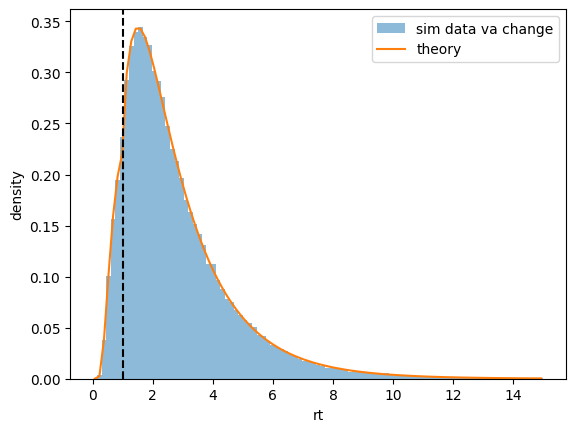

In [16]:
bins = np.linspace(0.001, 15, 100)
plt.hist(sim_results, bins=bins, density=True, alpha=0.5, label='sim data va change');


t_pts = bins[:-1] + np.diff(bins)/2
# # theory - raga
p_hit_theory = np.zeros_like(t_pts)
# area = quad(PDF_hit_V_A_change, 0, np.inf, args=(V_A_old, V_A_new, a, t_LED))[0]
# raga_pdf = np.array([PDF_hit_V_A(t, V_A_old, V_A_new, a, t_LED, area) for t in t_pts])
area = quad(PDF_hit_V_A_change_NO_AREA, 0, np.inf, args=(V_A_old, V_A_new, a, t_LED))[0]
print(area)
raga_pdf = np.array([PDF_hit_V_A_change_NO_AREA(t, V_A_old, V_A_new, a, t_LED) for t in t_pts])

plt.plot(t_pts, raga_pdf, label='theory')
plt.xlabel('rt')
plt.ylabel('density')

# Juan
area_juan = quad(Juan_PDF_hit_V_A_change, 0, np.inf, args=(V_A_old, V_A_new, a, t_LED))[0]
pdf_juan = np.array([Juan_PDF_hit_V_A_change(t, V_A_old, V_A_new, a, t_LED)/area_juan for t in t_pts])

# plt.plot(t_pts, pdf_juan, label='Juan theory', ls='--')
# plt.plot(t_pts, pdf_juan - raga_pdf, label='juan - raga')

plt.legend();
plt.axvline(t_LED, color='k', ls='--')

# check CDF

(0.0, 10.0)

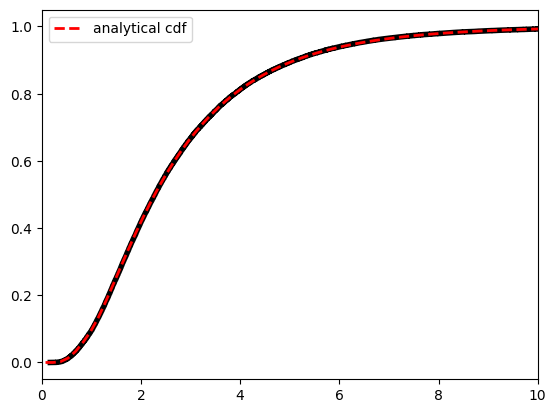

In [17]:
# data - CDF of sim_results
plt.figure()
data_sorted = np.sort(sim_results)

# Calculate the CDF values for each data point
cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

# Plot the CDF
# plt.step(data_sorted, cdf, marker=".", linestyle="none", color='k', label='data', where='post')
plt.step(data_sorted, cdf, where='post',color='k',lw=4)


analytical_cdf = np.array([CDF_hit_V_A_change_NO_AREA(t, V_A_old, V_A_new, a, t_LED) for t in t_pts])
# numerical_cdf = np.array([quad(PDF_hit_V_A_change_NO_AREA, 0.001, t, args=(V_A_old, V_A_new, a, t_LED))[0] for t in t_pts])
plt.plot(t_pts, analytical_cdf, label='analytical cdf', color='r',ls='--',lw=2)
# plt.plot(t_pts, numerical_cdf, label='numerical cdf', color='r')
plt.legend();
plt.xlim(0,10)

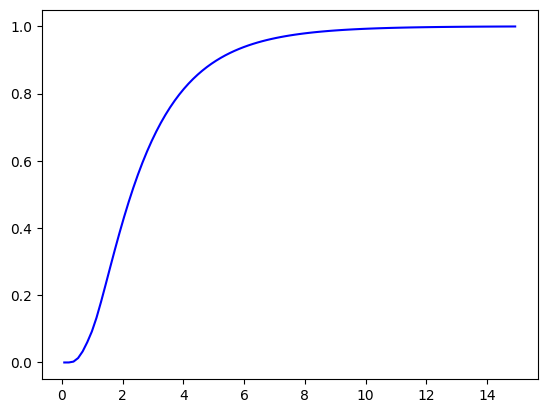

In [18]:
plt.plot(t_pts, analytical_cdf, label='analytical - data', color='b')

# are post led part correct?

In [19]:
def Juan_PDF_hit_V_A_change_Post_LED(t, V_A_old, V_A_new, a, t_LED):
    if t <= t_LED:
        return 0
    p = (1 - cum_A_t_fn(t_LED, V_A_old, a))*rho_A_t_fn(t, V_A_new, a)/(1 - cum_A_t_fn(t_LED, V_A_new, a))
    
    return p

Text(0.5, 1.0, ' ONly post LED')

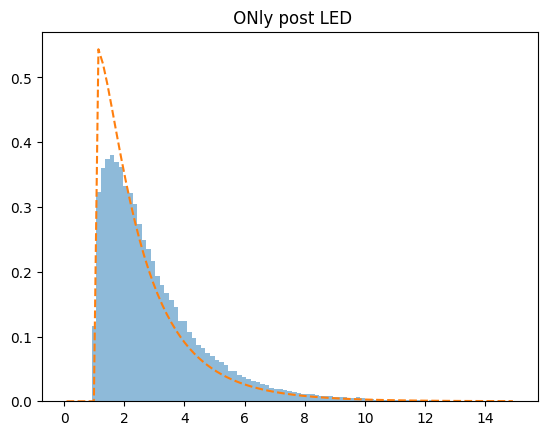

In [20]:
# sim_results > t_LED - data
sim_results_np = np.array(sim_results)
sim_results_post_LED = sim_results_np[sim_results_np > t_LED]
bins = np.linspace(0.001, 15, 100)
plt.hist(sim_results_post_LED, bins=bins, density=True, alpha=0.5, label='sim data va change post LED');

# theory
t_pts = bins[:-1] + np.diff(bins)/2
area = quad(Juan_PDF_hit_V_A_change_Post_LED, 0, np.inf, args=(V_A_old, V_A_new, a, t_LED))[0]
pdf_juan_post_LED = np.array([Juan_PDF_hit_V_A_change_Post_LED(t, V_A_old, V_A_new, a, t_LED)/area for t in t_pts])

plt.plot(t_pts, pdf_juan_post_LED, label='Juan theory post LED', ls='--')
plt.title(' ONly post LED')